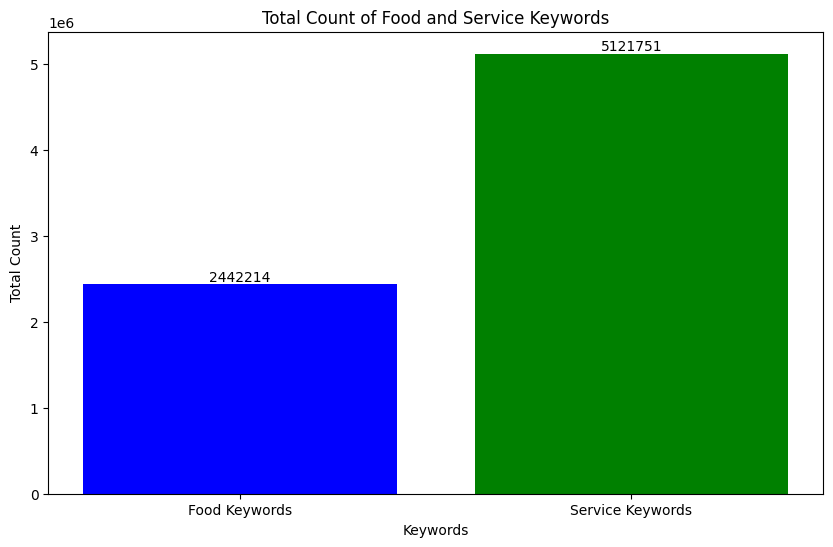

                                                    name  food_count  \
0                                "Genuino" Italian Cafe'         124   
1      #1 Mongolian BBQ - Best Stir Fried Noodles In ...          27   
2                                   $5 Fresh Burger Stop          16   
3                                         &pizza - UPenn          36   
4                                        &pizza - Walnut         102   
...                                                  ...         ...   
27057                                             zpizza           0   
27058                                            ¡CUATRO           8   
27059                                            ÀLAVITA         210   
27060                                Àrdana Food & Drink         181   
27061                                             ā café          99   

       service_count                                    category  
0                151   {'Service': 26, 'Food': 17, 'Neutral': 8}  
1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read review data
chunks = []
r_dtypes = {"stars": np.float16} 

reader = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_review.json',
                      lines=True,
                      chunksize=1000,
                      dtype=r_dtypes,
                      orient='records')

for chunk in reader:
    reduced_chunk = chunk.drop(columns=['review_id', 'user_id']).query("`date` >= '2018-12-31'")
    chunks.append(reduced_chunk)

reviews = pd.concat(chunks, ignore_index=True)

# Read business data
business = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_business.json',
                        lines=True, orient='records')

# Filter businesses that are categorized as restaurants
df_yelp_business_restaurants = business.loc[(business['categories'].str.contains('Restaurants', na=False))]

# Merge review data with restaurant business data
merged_data = pd.merge(reviews, df_yelp_business_restaurants[['business_id', 'name']], on='business_id', how='inner')

# Define keywords related to food and service
food_keywords = ['sick', 'food poisoning', 'hair', 'gross', 'portion', 'taste', 'dry', 'fresh', 'tasted', 'food', 'seasoned', 'bland', 'stale', 'tasty', 'tasted', 'texture', 'cooked', 'bite', 'crispy', 'soggy', 'raw', 'delicious']
service_keywords = ['service', 'waiter', 'waitress', 'staff', 'hospitality','employee', 'driver', 'cook', 'manager', 'pissed', 'disrespectful', 'treated', 'experience', 'team', 'operating', 'operation', 'waitress', 'waiter', 'customer service', 'greet', 'apology', 'rude', 'condescending', 'angry', 'atmosphere', 'vibe', 'request' , 'requested', 'service', 'slow', 'minutes', 'hours', 'arrived', 'closing', 'close', 'closed', 'wait', 'waiting', 'price', 'pricing', 'prices', 'server', 'loud', 'environment', 'staff', 'friendly', 'place', 'location', 'wave', 'ambience', 'forgot', 'forgetting', 'wrong', 'establishment', 'pricey', 'owner', 'interior', 'clean', 'comfortable', 'greeted', 'attentive']

# Function to count keyword occurrences
def count_keywords(text, keywords):
    count = 0
    for word in keywords:
        count += text.lower().count(word)
    return count

# Apply the function to each review
merged_data['food_count'] = merged_data['text'].apply(lambda x: count_keywords(x, food_keywords))
merged_data['service_count'] = merged_data['text'].apply(lambda x: count_keywords(x, service_keywords))

# Classify reviews based on counts
def classify(row):
    if row['food_count'] > row['service_count']:
        return 'Food'
    elif row['food_count'] < row['service_count']:
        return 'Service'
    else:
        return 'Neutral'

merged_data['category'] = merged_data.apply(classify, axis=1)

# Group by business name and summarize counts
grouped_reviews = merged_data.groupby('name').agg({
    'food_count': 'sum',
    'service_count': 'sum',
    'category': lambda x: x.value_counts().to_dict()
}).reset_index()

# Drop businesses that do not have any of the keywords
grouped_reviews = grouped_reviews[(grouped_reviews['food_count'] > 0) | (grouped_reviews['service_count'] > 0)]

# Plotting
keywords = ['Food Keywords', 'Service Keywords']
counts = [grouped_reviews['food_count'].sum(), grouped_reviews['service_count'].sum()]

plt.figure(figsize=(10, 6))
plt.bar(keywords, counts, color=['blue', 'green'])
plt.xlabel('Keywords')
plt.ylabel('Total Count')
plt.title('Total Count of Food and Service Keywords')
# Add numeric labels
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

# Print the filtered grouped_reviews dataframe
print(grouped_reviews)
